In [145]:
import pandas as pd
import numpy as np
import find_proposals_swaycounts as fps
import find_swaying_voters as fsv
import matplotlib.pyplot as plt
import identify_addresses as ia
import requests, json
from datetime import datetime
from dateutil.relativedelta import relativedelta
# To install the Python library and the command line utility, run: pip install tabulate
from tabulate import tabulate
from convert_to_compound import parse_event_csv
#from get_ens_name import get_ens_name
import time
import os

image_path = "../figures"
latex_path = "../macros"

In [146]:
nbname = "data_viz.ipynb"
try:
    nbname = os.path.basename(__name__)
except Exception as e:
    try:
        import ipynbname
        nbname = ipynbname.name()
    except Exception as ee:
        pass

In [147]:
compound_csvs = ["../data/compound_governor_alpha.csv", "../data/compound_governor_bravo.csv"]
uniswap_csvs = ["../data/uniswap_governor_alpha.csv", "../data/uniswap_governor_alphav2.csv", "../data/uniswap_governor_bravo.csv"]
lido_csvs = ["../data/lido_governance.csv"]
aave_csvs = ["../data/aave_governance_v2.csv"]
platforms = ['Compound', 'Uniswap', 'Lido', 'Aave']
combined_csvs = [compound_csvs, uniswap_csvs, lido_csvs, aave_csvs]
csvs_dict = dict(zip(platforms, combined_csvs))



In [148]:
governance_supplies = pd.read_csv("../data/governance_token_supplies.csv")
governance_supplies['supply'] =  governance_supplies['supply'].astype(float) / 1e18
symbol_to_platform = {'UNI':'Uniswap', 'COMP':'Compound', 'LDO':'Lido', 'AAVE':'Aave'}
governance_supplies['platform'] = governance_supplies['symbol'].map(symbol_to_platform)

governance_supplies_dict = pd.Series(
    governance_supplies['supply'].values,index=['Aave', 'Uniswap', 'Compound', 'Lido', 'MakerDAO']).to_dict()

percent_needed_dict = {'Compound': .04, 'Uniswap': .04, 'Lido': .05, 'Aave': .02}

min_vote_thresholds = {}

for x in platforms:
    min_vote_thresholds[x] = governance_supplies_dict[x] * percent_needed_dict[x]

min_vote_threshold_dict = dict(zip(platforms, min_vote_thresholds))


In [149]:
#Create events df
events_dfs = {}
for x in platforms:
    df = None
    for event_csv in csvs_dict[x]:
        events_df = parse_event_csv(event_csv)
        df = pd.concat( [df,events_df] )
    events_dfs[x] = df
    print( x )
    print( events_dfs[x].head() )

Compound
        event_name  block_number           timestamp   id  \
0  ProposalCreated       9951904 2020-04-27 02:41:52  1.0   
1         VoteCast       9952490 2020-04-27 04:54:53  NaN   
2         VoteCast       9952737 2020-04-27 05:51:06  NaN   
3         VoteCast       9952767 2020-04-27 05:56:47  NaN   
4         VoteCast       9953038 2020-04-27 06:53:45  NaN   

                                         description  \
0  # Add USDT Support\nIn a September 2019 vote, ...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                        voter  proposalId  support     votes  \
0                                         NaN         1.0      NaN       NaN   
1  0xb0325DbE7fA891436E83A094f9F12848c78e449b         1.0      1.0  24107.64   
2  0x181fC4A2B228c0e0f996B736F0310Cf9B2e34b56  

In [150]:
#Creating dfs with proposal descriptions
#Note that Uniswap Proposal 5 has two similar (but not identical) descriptions
descriptions_dfs = {}
for x in ['Compound','Uniswap','Lido','Aave']:
    df = events_dfs[x]
    print( x )
    #print( df[df.proposalId == 5].description.unique() )
    #print( df.description.unique() )
    descriptions_dfs[x] = df[ (df.description != '""') & (df.description != "") & (df.description.notna()) & (df.description != "nan")][['description','proposalId']]
    #print( descriptions_dfs[x].head() )
    #print( df[ (df.description != '""') & (df.description != "") & (df.description.notna()) & (df.description != "nan")][['description','proposalId']].groupby('proposalId').size() )
    #print( df[ (df.proposalId != df.id) & df.proposalId.notnull() & df.id.notnull() ] )
    #print( df[ (df.proposalId == df.id) & df.proposalId.notnull() & df.id.notnull() ] )
    #print( df[df.description.notnull()].id.unique() )

Compound
Uniswap
Lido
Aave


**Basic Stats**

In [151]:
basic_stats_dfs = {}
num_proposals = {}
avg_num_voters = {}
avg_supply_percent = {}
latex_vars = {}
voters = {}

for x in platforms:
    
    basic_stats = pd.DataFrame(columns=['proposalId', 'num_voters', 'votes_cast',
                                        'result', 'timestamp', 'percent_supply_cast'])
   
    events_df = events_dfs[x]

    ######
    #Platform-level variables to be exported to latex macros
    start_date = events_df.timestamp.min()
    if f'{x}SD' in latex_vars.keys():
         latex_vars[f'{x}SD'] = min( start_date, latex_vars[f'{x}SD'] )
    else:
        latex_vars[f'{x}SD'] = start_date
    end_date = events_df.timestamp.max()
    if f'{x}ED' in latex_vars.keys():
         latex_vars[f'{x}ED'] = max( end_date, latex_vars[f'{x}ED'] )
    else:
        latex_vars[f'{x}ED'] = end_date

    if x in voters.keys():
        voters[x] = voters[x].union( events_df.voter.unique() )
    else:
        voters[x] = set(events_df.voter.unique() )

    num_props = len(events_df.proposalId.unique())
    if f'{x}NP' in latex_vars.keys():
         latex_vars[f'{x}NP'] += num_props
    else:
        latex_vars[f'{x}NP'] = num_props
    #######

    for proposalId in events_df['proposalId'].dropna().unique():

        proposal_events = events_df.loc[(events_df['proposalId'] == proposalId)]

        proposal_votes = proposal_events.loc[proposal_events['event_name'] == 'VoteCast']
        num_voters = len(proposal_votes.index)
        votes_cast = proposal_votes['votes'].sum()

        event_names = events_df.loc[events_df['id'] == proposalId, 'event_name']
        if not event_names.empty:
            latest_event_name = event_names.iloc[-1]
        else:
            latest_event_name = np.nan

        timestamp = proposal_events['timestamp'].iloc[-1] #Date of last vote cast on proposal

        percent_supply_cast = votes_cast / governance_supplies_dict[x] * 100
        new_proposal = pd.DataFrame({'proposalId':[proposalId], 'num_voters':num_voters,
                                     'votes_cast':votes_cast, 'result': latest_event_name,
                                     'timestamp':timestamp,
                                     'percent_supply_cast':percent_supply_cast})

        basic_stats = pd.concat([basic_stats if not basic_stats.empty else None, new_proposal], ignore_index=True)

    latex_vars[f'{x}NV'] = len(voters[x]) #Get the total number of distinct voters across all csvs
    latex_vars[f'{x}SD'] = latex_vars[f'{x}SD'].strftime("%B %Y" ) #Format start date
    
    basic_stats_dfs[x] = basic_stats.astype( {'proposalId': int, 'num_voters': int, 'votes_cast': float, 'percent_supply_cast': float } )
    
#     print(f"Number of {x} proposals: {len(basic_stats_dfs[x].index)}")
    num_proposals[x] = len(basic_stats_dfs[x].index)
    
#     print(f"Average number of voters on {x} proposals: {basic_stats_dfs[x]['num_voters'].mean()}")
    avg_num_voters[x] = basic_stats_dfs[x]['num_voters'].mean()
    
#     print(f"Average percentage of total token supply cast on {x} proposals: {round(percent_supply_cast, 2)}")
    avg_supply_percent[x] = basic_stats_dfs[x]['percent_supply_cast'].mean()

   
latex_vars['ED'] = max( latex_vars[f'{x}ED'] for x in platforms ).strftime("%B %Y")
for x in platforms:
    latex_vars[f'{x}ED'] = latex_vars[f'{x}ED'].strftime("%B %Y" ) #Format end date

In [152]:
#Write variables to file where they can be read as LaTeX macros

with open( f"{latex_path}/stat_macros.tex", "w" ) as f:
    f.write( f"%Created by {nbname}\n")
    f.write( f"%Do not modify\n")
    for k,v in latex_vars.items():
        f.write( "\\newcommand{\\" + str(k) + "}{" + str(v) + "\\xspace}\n" )
        print( f"{k} : {v}" )
    

CompoundSD : April 2020
CompoundED : December 2022
CompoundNP : 142
CompoundNV : 3500
UniswapSD : October 2020
UniswapED : December 2022
UniswapNP : 30
UniswapNV : 11348
LidoSD : December 2020
LidoED : December 2022
LidoNP : 150
LidoNV : 139
AaveSD : December 2020
AaveED : December 2022
AaveNP : 131
AaveNV : 6629
ED : December 2022


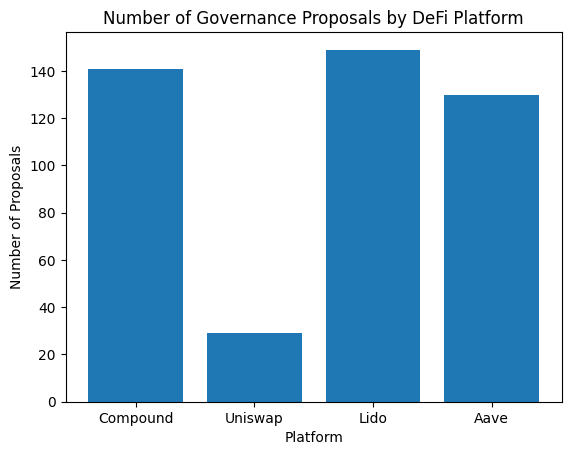

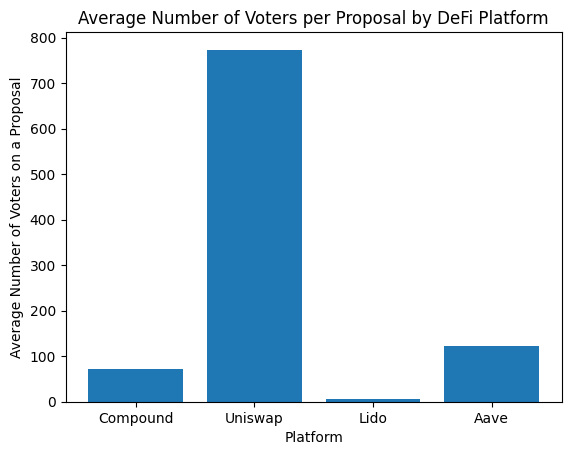

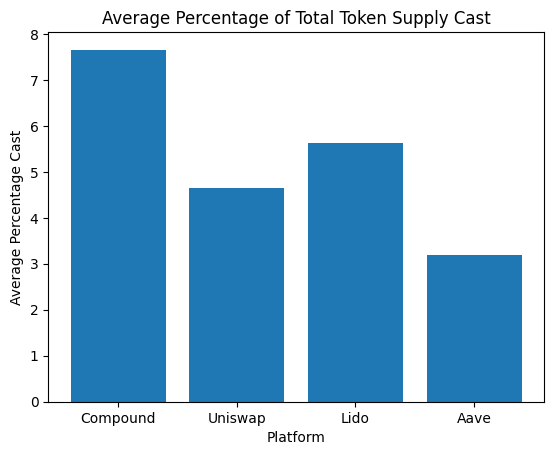

In [153]:
plt.bar(platforms, list(num_proposals.values()))
plt.xlabel("Platform")
plt.ylabel("Number of Proposals")
plt.title("Number of Governance Proposals by DeFi Platform")
plt.savefig(f"{image_path}/num_proposals.pdf")
plt.show()

# can we get number of addresses that hold tokens, and see what is average percentage of voter participation
plt.bar(platforms, list(avg_num_voters.values()))
plt.xlabel("Platform")
plt.ylabel("Average Number of Voters on a Proposal")
plt.title("Average Number of Voters per Proposal by DeFi Platform")
plt.savefig(f"{image_path}/num_voters.pdf")
plt.show()

plt.bar(platforms, list(avg_supply_percent.values()))
plt.xlabel("Platform")
plt.ylabel("Average Percentage Cast")
plt.title("Average Percentage of Total Token Supply Cast")
plt.savefig(f"{image_path}/tokensupply_cast.pdf")
plt.show()

# other stats

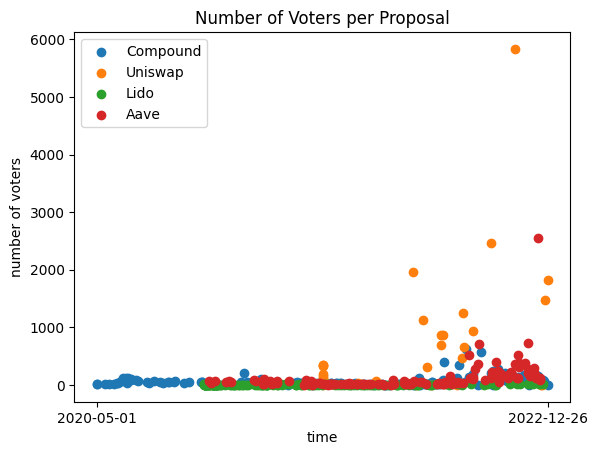

In [154]:
first_date = datetime.now()
last_date = datetime.now() - relativedelta(years=100)

for x in platforms:
    # we have block numbers for lido events, but not timestamps
    if not basic_stats_dfs[x]['timestamp'].isnull().all():
        timestamps = basic_stats_dfs[x]['timestamp']
        plt.scatter(timestamps, basic_stats_dfs[x]['num_voters'], label=x)
        if min(timestamps) < first_date:
            first_date = min(timestamps)
        if max(timestamps) > last_date:
            last_date = max(timestamps)
plt.xticks([first_date, last_date])
plt.xlabel("time")
plt.ylabel("number of voters")
plt.legend(loc="upper left")
plt.title("Number of Voters per Proposal")
plt.savefig(f"{image_path}/num_votes_per_proposal.pdf")
plt.show()

In [155]:
#Find proposals where a lot of votes were cast
from scipy import stats

outliers = {}

for x in platforms:
    outlier_df = pd.DataFrame( {'proposalId': basic_stats_dfs[x].proposalId, 'numZ': np.abs(stats.zscore( basic_stats_dfs[x].num_voters ) ), 'voteZ': np.abs(stats.zscore( basic_stats_dfs[x].votes_cast ) ) } ).sort_values( by=['voteZ','numZ'],ascending=False )
    outlier_df = outlier_df.merge( events_dfs[x][['proposalId','description']], how='left', on='proposalId' )
    outliers[x] = outlier_df
    
    print( x )
    print( outliers[x].head() )
    
#Aave proposals can be found at https://app.aave.com/governance/proposal/{proposalId}

Compound
   proposalId      numZ    voteZ  \
0          59  0.423038  2.64789   
1          59  0.423038  2.64789   
2          59  0.423038  2.64789   
3          59  0.423038  2.64789   
4          59  0.423038  2.64789   

                                         description  
0  # Distribute DAI to Users Affected in the DAI ...  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
Uniswap
   proposalId      numZ     voteZ  \
0           5  0.364152  1.884209   
1           5  0.364152  1.884209   
2           5  0.364152  1.884209   
3           5  0.364152  1.884209   
4           5  0.364152  1.884209   

                                         description  
0  # DeFi Education Fund\n\n\nProposal to allocat...  
1                                                NaN  
2                                               

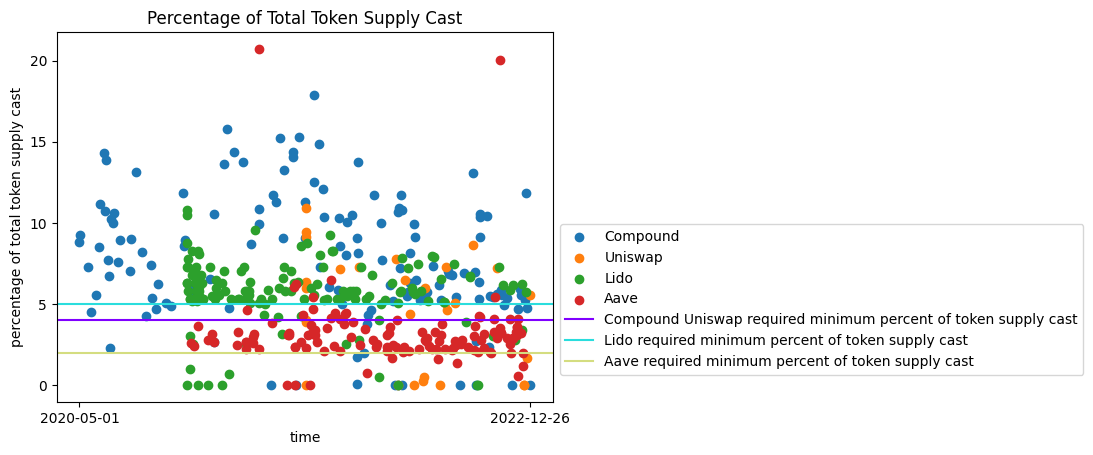

In [156]:
first_date = datetime.now()
last_date = datetime.now() - relativedelta(years=100)

for x in platforms:
    # we have block numbers for lido events, but not timestamps
    if not basic_stats_dfs[x]['timestamp'].isnull().all():
        timestamps = basic_stats_dfs[x]['timestamp']
        if min(timestamps) < first_date:
            first_date = min(timestamps)
        if max(timestamps) > last_date:
            last_date = max(timestamps)
        
        plt.scatter(timestamps, basic_stats_dfs[x]['percent_supply_cast'], label=x)
        
# need to update if Aave and Lido are added to this graph
# plt.axhline(y=percent_needed_dict['Compound'] * 100, color=c, linestyle='-',
#             label='Uniswap and Compound required minimum percent of token supply cast')
# plt.axhline(y=percent_needed_dict['Lido'] * 100, color=c, linestyle='-',
#             label='Lido required minimum percent of token supply cast')
# plt.axhline(y=percent_needed_dict['Aave'] * 100, color=c, linestyle='-',
#             label='Aave required minimum percent of token supply cast')

percent_needed_flipped = {}
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(platforms))))

for x in percent_needed_dict:
    if percent_needed_dict[x] in percent_needed_flipped.keys():
        current_list = percent_needed_flipped[percent_needed_dict[x]]
        current_list.append(x)
        percent_needed_flipped[percent_needed_dict[x]] = current_list
    else:
        percent_needed_flipped[percent_needed_dict[x]] = [x]

for i in percent_needed_flipped:
    label = ''
    for j in percent_needed_flipped[i]:
        label = label + f'{j} '
    c = next(color)
    plt.axhline(y=percent_needed_dict[j] * 100, color=c, linestyle='-',
            label= label + 'required minimum percent of token supply cast')
    
        
plt.xticks([first_date, last_date])
plt.xlabel("time")
plt.ylabel("percentage of total token supply cast")
plt.legend(loc="upper left", bbox_to_anchor = (1, 0.5))
plt.title("Percentage of Total Token Supply Cast")
plt.savefig(f"{image_path}/pct_supply_per_proposal.pdf")
plt.show()

In [157]:
basic_stats_table = pd.DataFrame(columns=['platform', 'num_proposals', 'avg_num_voters', 'avg_supply_cast'])

for x in platforms:
    basic_stats_table.loc[len(basic_stats_table.index)] = [x, len(basic_stats_dfs[x].index),
                                                           avg_num_voters[x],
                                                          avg_supply_percent[x]]

    
basic_stats_table.sort_values(by="platform",inplace=True)
table_headers = ['Platform', 'Number of Proposals', 'Avg Number of Voters', 'Avg Pct of \n Total Token Supply Cast']
print(tabulate(basic_stats_table,
               headers= table_headers,
               tablefmt='fancy_grid', numalign="center"))


#latex_table = basic_stats_table.to_latex(buf=None,header=table_headers,label="tab:summary",index=False)
latex_table = basic_stats_table.style.hide(axis='index').format({'avg_supply_cast':'{:,.1f}\%','avg_num_voters':'{:,.1f}'}).relabel_index(table_headers,axis='columns').to_latex(label="tab:summary",clines="all;data",hrules=True,column_format="|l|c|c|c|",caption='Overview of voting activity')
latex_table = latex_table.replace("\\\\","\\\\ \\hline" )
latex_table = latex_table.replace("\\toprule","\\hline" )
latex_table = latex_table.replace("\\midrule","" )
latex_table = latex_table.replace("\\bottomrule","" )
print(latex_table)
with open( f"{latex_path}/vote_counts.tex", "w" ) as f:
    f.write( f"%Created by {nbname}\n")
    f.write( f"%Do not modify\n")
    f.write(latex_table)


╒════╤════════════╤═══════════════════════╤════════════════════════╤════════════════════════════╕
│    │ Platform   │  Number of Proposals  │  Avg Number of Voters  │        Avg Pct of          │
│    │            │                       │                        │   Total Token Supply Cast  │
╞════╪════════════╪═══════════════════════╪════════════════════════╪════════════════════════════╡
│ 3  │ Aave       │          130          │        121.754         │          3.20012           │
├────┼────────────┼───────────────────────┼────────────────────────┼────────────────────────────┤
│ 0  │ Compound   │          141          │        71.9787         │          7.65514           │
├────┼────────────┼───────────────────────┼────────────────────────┼────────────────────────────┤
│ 2  │ Lido       │          149          │        6.49664         │          5.62785           │
├────┼────────────┼───────────────────────┼────────────────────────┼────────────────────────────┤
│ 1  │ Uniswap    │ 

**Decentralization**

In [158]:
min_quorums_dfs = {}
min_quorums_avgs = {}
min_quorums_std = {}
total_voter_avgs = pd.DataFrame(columns=['platform', 'total_voters'])
for x in platforms:
    min_quorums_dfs[x] = fps.build_swaycounts_min(csvs_dict[x])
#     print(f"Number of {x} proposals: {min_quorums_dfs[x].shape[0]}")
#     print(f"Average minimal quorum for {x} proposals: {min_quorums_dfs[x]['min_voters'].mean()}")
#     print(f"Standard deviation of minimal quorum on {x} proposals: {min_quorums_dfs[x]['min_voters'].std()}")
#     print(f"Average number of voters on {x} proposals: {min_quorums_dfs[x]['total_voters'].mean()}")
    min_quorums_avgs[x] = min_quorums_dfs[x]['min_voters'].mean()
    min_quorums_std[x] = min_quorums_dfs[x]['min_voters'].std()
    total_voter_avgs.loc[len(total_voter_avgs.index)] = [x, min_quorums_dfs[x]['total_voters'].mean()]
#     print()
    

    

/Users/brett/sandbox/dao-governance/analysis/find_proposals_swaycounts.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  swaycounts_min = pd.concat([swaycounts_min, new_proposal], ignore_index=True)
/Users/brett/sandbox/dao-governance/analysis/find_proposals_swaycounts.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  swaycounts_min = pd.concat([swaycounts_min, new_proposal], ignore_index=True)
/Users/brett/sandbox/dao-governance/analysis/find_proposals_swaycounts.py:71: FutureWarning: The

In [159]:
print(total_voter_avgs.iloc[0, 1])

74.65248226950355


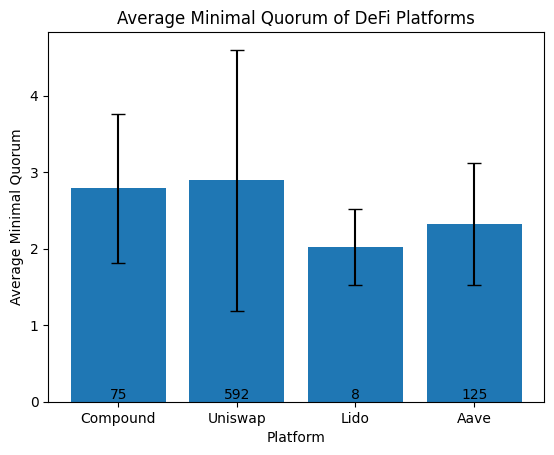

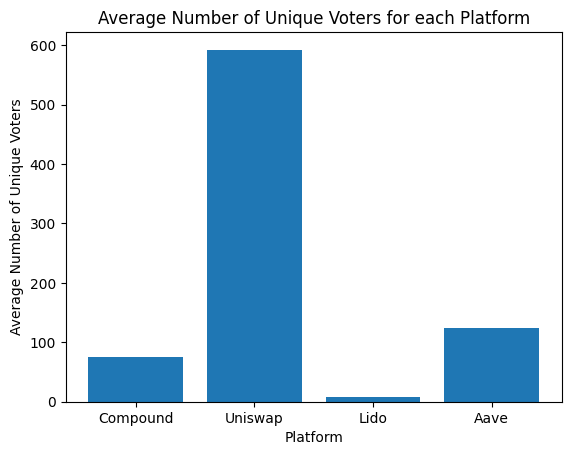

In [160]:
bar1 = plt.bar(platforms, list(min_quorums_avgs.values()), yerr=list(min_quorums_std.values()),capsize=5)

plt.xlabel("Platform")
plt.ylabel("Average Minimal Quorum")
plt.title("Average Minimal Quorum of DeFi Platforms")
#plt.figtext(0.1,-0.01,'*Numbers in bars are average number of voters per proposal')
for i in range(len(bar1)):
    height = bar1[i].get_height()
    plt.text(bar1[i].get_x() + bar1[i].get_width() / 2.0, 0, f'{total_voter_avgs.iloc[i, 1]:.0f}', ha='center', va='bottom')

plt.savefig(f"{image_path}/avg_minimal_quorum.pdf")
plt.show()

plt.bar(platforms, total_voter_avgs['total_voters'])
plt.xlabel("Platform")
plt.ylabel("Average Number of Unique Voters")
plt.title("Average Number of Unique Voters for each Platform")
plt.savefig(f"{image_path}/avg_num_unique.pdf")
plt.show()

In [161]:
actual_quorums_dfs = {}
actual_quorums_avgs = {}
actual_quorums_std = {}
# total_voter_avgs = pd.DataFrame(columns=['platform', 'total_voters'])
for x in platforms:
    actual_quorums_dfs[x] = fps.build_swaycounts_actual(csvs_dict[x])
#     print(f"Number of {x} proposals: {actual_quorums_dfs[x].shape[0]}")
#     print(f"Average minimal quorum for {x} proposals: {actual_quorums_dfs[x]['actual_to_sway'].mean()}")
#     print(f"Standard deviation of minimal quorum on {x} proposals: {actual_quorums_dfs[x]['actual_to_sway'].std()}")
#     print(f"Average number of voters on {x} proposals: {actual_quorums_dfs[x]['total_voters'].mean()}")
    actual_quorums_avgs[x] = actual_quorums_dfs[x]['actual_to_sway'].mean()
    actual_quorums_std[x] = actual_quorums_dfs[x]['actual_to_sway'].std()
# #     total_voter_avgs.loc[len(total_voter_avgs.index)] = [x, min_quorums_dfs[x]['total_voters'].mean()]
#     print()

/Users/brett/sandbox/dao-governance/analysis/find_proposals_swaycounts.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  swaycounts_actual_byweight = pd.concat([swaycounts_actual_byweight, new_proposal], ignore_index=True)
/Users/brett/sandbox/dao-governance/analysis/find_proposals_swaycounts.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  swaycounts_actual_byweight = pd.concat([swaycounts_actual_byweight, new_proposal], ignore_index=True)
/Users/brett/sandbox/dao-governance/analysis/f

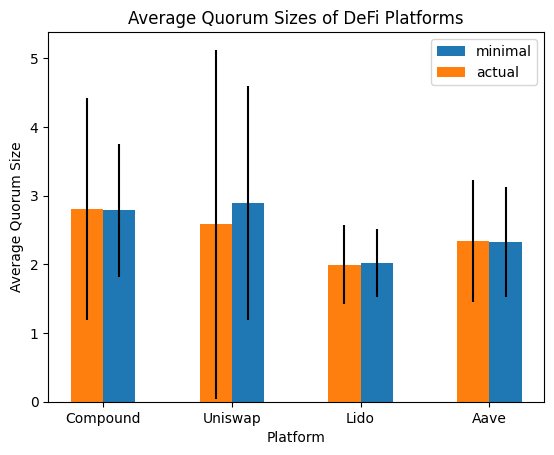

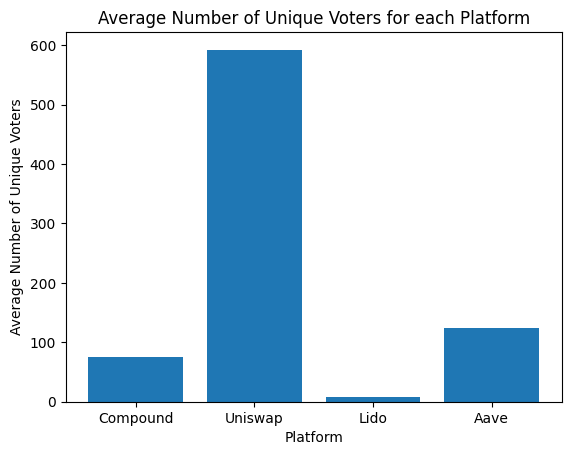

In [162]:
width = 0.25
bar1 = plt.bar(platforms, list(min_quorums_avgs.values()), width=width, align='edge',
               yerr=list(min_quorums_std.values()), label='minimal')
bar2 = plt.bar(platforms, list(actual_quorums_avgs.values()), width=-width, align='edge',
               yerr=list(actual_quorums_std.values()), label='actual')
plt.xlabel("Platform")
plt.ylabel("Average Quorum Size")
plt.title("Average Quorum Sizes of DeFi Platforms")
plt.legend()

plt.savefig(f"{image_path}/avg_quorums.pdf")
plt.show()

plt.bar(platforms, total_voter_avgs['total_voters'])
plt.xlabel("Platform")
plt.ylabel("Average Number of Unique Voters")
plt.title("Average Number of Unique Voters for each Platform")
plt.show()

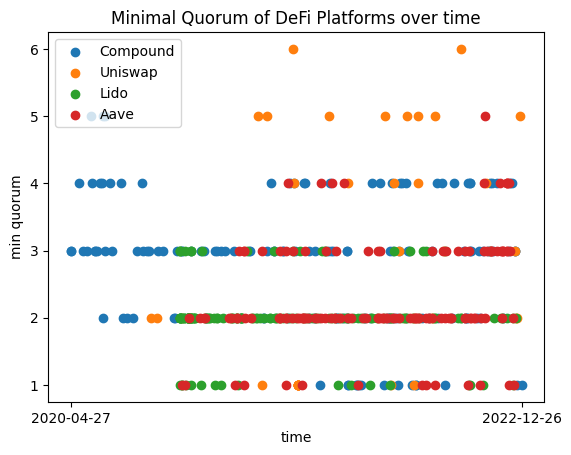

In [163]:
first_date = datetime.now()
last_date = datetime.now() - relativedelta(years=100)

for x in platforms:
    timestamps = min_quorums_dfs[x]['timestamp']
    plt.scatter(timestamps, min_quorums_dfs[x]['min_voters'], label=x)
    if min(timestamps) < first_date:
        first_date = min(timestamps)
    if max(timestamps) > last_date:
        last_date = max(timestamps)
plt.xticks([first_date, last_date])
plt.xlabel("time")
plt.ylabel("min quorum")
plt.legend(loc="upper left")
plt.title("Minimal Quorum of DeFi Platforms over time")
plt.savefig(f"{image_path}/min_quorum_over_time.pdf")
plt.show()


In [164]:
min_quorum_table = pd.DataFrame(columns=['platform', 'avg_min_quorum', 'avg_total_voters'])

for x in platforms:
    min_quorum_table.loc[len(min_quorum_table.index)] = [x, min_quorums_avgs[x], min_quorums_dfs[x]['total_voters'].mean()]
    
print(tabulate(min_quorum_table,
               headers=['Platform', 'Average Minimal Quorum', 'Average Number of Unique Voters'],
               tablefmt='fancy_grid'))

╒════╤════════════╤══════════════════════════╤═══════════════════════════════════╕
│    │ Platform   │   Average Minimal Quorum │   Average Number of Unique Voters │
╞════╪════════════╪══════════════════════════╪═══════════════════════════════════╡
│  0 │ Compound   │                  2.78723 │                           74.6525 │
├────┼────────────┼──────────────────────────┼───────────────────────────────────┤
│  1 │ Uniswap    │                  2.89474 │                          592.263  │
├────┼────────────┼──────────────────────────┼───────────────────────────────────┤
│  2 │ Lido       │                  2.02013 │                            8.3557 │
├────┼────────────┼──────────────────────────┼───────────────────────────────────┤
│  3 │ Aave       │                  2.32308 │                          124.523  │
╘════╧════════════╧══════════════════════════╧═══════════════════════════════════╛


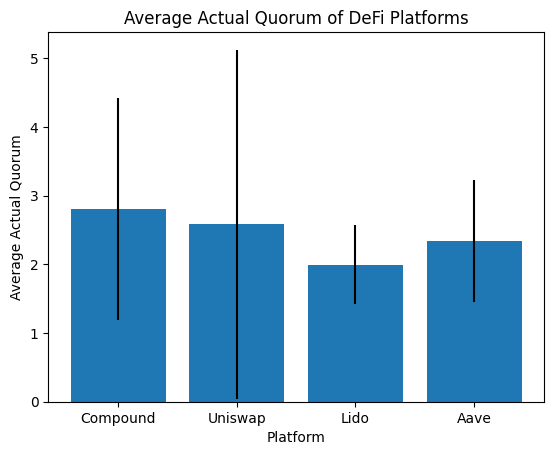

In [165]:
plt.bar(platforms, list(actual_quorums_avgs.values()), yerr=list(actual_quorums_std.values()))
plt.xlabel("Platform")
plt.ylabel("Average Actual Quorum")
plt.title("Average Actual Quorum of DeFi Platforms")
plt.show()


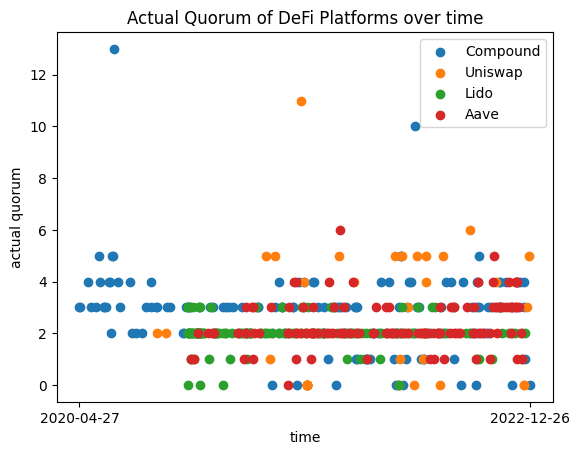

In [166]:
first_date = datetime.now()
last_date = datetime.now() - relativedelta(years=100)

for x in platforms:
    # we have block numbers for lido events, but not timestamps
    if not actual_quorums_dfs[x]['timestamp'].isnull().all():
        timestamps = actual_quorums_dfs[x]['timestamp']
        plt.scatter(timestamps, actual_quorums_dfs[x]['actual_to_sway'], label=x)
        if min(timestamps) < first_date:
            first_date = min(timestamps)
        if max(timestamps) > last_date:
            last_date = max(timestamps)
plt.xticks([first_date, last_date])
plt.xlabel("time")
plt.ylabel("actual quorum")
plt.legend(loc="upper right")
plt.title("Actual Quorum of DeFi Platforms over time")
plt.show()

In [167]:
actual_quorum_table = pd.DataFrame(columns=['platform', 'avg_actual_quorum', 'avg_actual_voters'])

for x in platforms:
    actual_quorum_table.loc[len(actual_quorum_table.index)] = [x, actual_quorums_avgs[x],
                                                         actual_quorums_dfs[x]['total_voters'].mean()]
    
print(tabulate(actual_quorum_table,
               headers=['Platform', 'Average Actual Quorum', 'Average Number of Unique Voters'],
               tablefmt='fancy_grid'))

╒════╤════════════╤═════════════════════════╤═══════════════════════════════════╕
│    │ Platform   │   Average Actual Quorum │   Average Number of Unique Voters │
╞════╪════════════╪═════════════════════════╪═══════════════════════════════════╡
│  0 │ Compound   │                 2.80142 │                           74.6525 │
├────┼────────────┼─────────────────────────┼───────────────────────────────────┤
│  1 │ Uniswap    │                 2.57895 │                          592.263  │
├────┼────────────┼─────────────────────────┼───────────────────────────────────┤
│  2 │ Lido       │                 1.99329 │                            8.3557 │
├────┼────────────┼─────────────────────────┼───────────────────────────────────┤
│  3 │ Aave       │                 2.33846 │                          124.523  │
╘════╧════════════╧═════════════════════════╧═══════════════════════════════════╛


In [168]:
mquorum_members_dfs = {}

for x in platforms:
    mquorum_members_dfs[x] = fsv.make_mquorum_members_dfs(csvs_dict[x]).sort_values(by='whale_count', ascending=False)
    print(f"Total number of voters in all {x} minimal quorums: {mquorum_members_dfs[x]['whale_count'].sum()}")
    print(f"Unique number of voters in all {x} minimal quorums: {len(mquorum_members_dfs[x].index)}")
    print(mquorum_members_dfs[x])
    print()
    


Total number of voters in all Compound minimal quorums: 393
Unique number of voters in all Compound minimal quorums: 53
                                         voter whale_count
6   0x54A37d93E57c5DA659F508069Cf65A381b61E189          46
13  0x9AA835Bc7b8cE13B9B0C9764A52FbF71AC62cCF1          41
12  0x6626593C237f530D15aE9980A95ef938Ac15c35c          34
25  0x88FB3D509fC49B515BFEb04e23f53ba339563981          33
30  0x683a4F9915D6216f73d6Df50151725036bD26C02          32
31  0xea6C3Db2e7FCA00Ea9d7211a03e83f568Fc13BF7          30
0   0xeD409c9fF60f3020abF9012bcd45Fc294f5608fF          20
29  0x8d07D225a769b7Af3A923481E1FdF49180e6A265          20
1   0x8169522c2C57883E8EF80C498aAB7820dA539806          20
9   0xAC5720d6EE2d7872b88914C9c5Fa9BF38e72FaF6          20
3   0x7e4A8391C728fEd9069B2962699AB416628B19Fa          12
26  0xd5447A7aa223268398CF7c38c2c580622CC98772          10
33  0xa6e8772af29b29B9202a073f8E36f447689BEef6           5
7   0xA1b61405791170833070C0eA61eD28728A840241        

In [169]:
print( platforms )
print( mquorum_members_dfs.keys() )
for x in mquorum_members_dfs.keys():
    print( x )
    print( mquorum_members_dfs[x].head() )

['Compound', 'Uniswap', 'Lido', 'Aave']
dict_keys(['Compound', 'Uniswap', 'Lido', 'Aave'])
Compound
                                         voter whale_count
6   0x54A37d93E57c5DA659F508069Cf65A381b61E189          46
13  0x9AA835Bc7b8cE13B9B0C9764A52FbF71AC62cCF1          41
12  0x6626593C237f530D15aE9980A95ef938Ac15c35c          34
25  0x88FB3D509fC49B515BFEb04e23f53ba339563981          33
30  0x683a4F9915D6216f73d6Df50151725036bD26C02          32
Uniswap
                                         voter whale_count
3   0x2B1Ad6184a6B0fac06bD225ed37C2AbC04415fF4          15
5   0xA2BF1B0a7E079767B4701b5a1D9D5700eB42D1d1          13
20  0x683a4F9915D6216f73d6Df50151725036bD26C02           8
21  0x8962285fAac45a7CBc75380c484523Bb7c32d429           7
18  0xB0623C91c65621df716aB8aFE5f66656B21A9108           7
Lido
                                         voter whale_count
1   0xb842aFD82d940fF5D8F6EF3399572592EBF182B0          85
5   0x1f3813fE7ace2a33585F1438215C7F42832FB7B3          70
0 

In [170]:
universities = { "UCLA": ["Blockchain at UCLA","blockchainatucla.eth","blockchainucla"],
                "Penn": ["Penn Blockchain,upennblockchain.eth,PennBlockchain",],
                "Columbia": ["blockchaincolumbia.eth"],
                "Stanford": ["Stanford Blockchain Club"],
                "Michigan": ["Blockchain at Michigan","UMichBlockchain"],
               "MIT": ["Blockchain at MIT","MITBitcoinClub"],
               "Harvard": ["HarvardLawBFI"],
               "Berkeley": ["Blockchain at Berkeley","CalBlockchain"]}
target_ids = { "Gauntlet": ["Gauntlet"],
              "a16z": ["a16z"],
              "MonetSupply": ["MonetSupply"],
              "Bain Capital Ventures": ["Bain Capital Ventures"],
              "Polychain Capital": ["Polychain Capital"],
              "Robert Leshner": ["Robert Leshner","rleshner"],
              "Pantera Capital": ["Pantera Capital","FranklinBi"],
              "Kain Warwick": ["Kain | Synthetix","kain.eth"],
              "blck": ["blck"],
              "Uniswap Grants Program": ["johnpalmer.eth","john_c_palmer"],
             "University Clubs": [v for u in universities.values() for v in u] }
categorized_addresses = pd.read_csv('../data/categorized_addresses.csv')

rows = { k: {} for k in target_ids.keys() }
for x in platforms:
    x_mquorum_df = mquorum_members_dfs[x].copy()
    x_mquorum_df = x_mquorum_df.merge( categorized_addresses, how="left", on="voter" )
    for k,v in target_ids.items():
        num_votes = x_mquorum_df[x_mquorum_df.compound_name.isin(v) | x_mquorum_df.ens_name.isin(v) | x_mquorum_df.sybil_name.isin(v)]['whale_count'].sum()
        rows[k].update( {x: num_votes } ) 
        
rows = [ {'Voter':k, **v} for k,v in rows.items() ]
tagged_voter_df = pd.DataFrame(rows)
tagged_voter_df = tagged_voter_df.loc[(tagged_voter_df.Aave + tagged_voter_df.Compound + tagged_voter_df.Lido + tagged_voter_df.Uniswap).sort_values(ascending=False).index,:]
print( tagged_voter_df )

latex_table = tagged_voter_df.style.hide(axis='index').to_latex(label="tab:category_counts",position_float="centering",clines="all;data",hrules=True,column_format="|l|c|c|c|c|",caption="Number of proposals for which the voter was a member of the minimal quorum")
latex_table = latex_table.replace("\\\\","\\\\ \\hline" )
latex_table = latex_table.replace("\\toprule","\\hline" )
latex_table = latex_table.replace("\\midrule","" )
latex_table = latex_table.replace("\\bottomrule","" )
print(latex_table)
with open( f"{latex_path}/category_count_table.tex", "w" ) as f:
    f.write( f"%Created by {nbname}\n")
    f.write( f"%Do not modify\n")
    f.write(latex_table)
    

                     Voter  Compound  Uniswap  Lido  Aave
0                 Gauntlet        66       10     0     1
4        Polychain Capital        61        0     0     0
1                     a16z        44       15     0     0
5           Robert Leshner        53        4     0     0
10        University Clubs         5       15     0    30
8                     blck        46        0     0     0
2              MonetSupply        20        0     0     0
9   Uniswap Grants Program         0        7     0     0
3    Bain Capital Ventures         5        0     0     0
7             Kain Warwick         4        0     0     0
6          Pantera Capital         0        0     0     3
\begin{table}
\centering
\caption{Number of proposals for which the voter was a member of the minimal quorum}
\label{tab:category_counts}
\begin{tabular}{|l|c|c|c|c|}
\hline
Voter & Compound & Uniswap & Lido & Aave \\ \hline

Gauntlet & 66 & 10 & 0 & 1 \\ \hline
Polychain Capital & 61 & 0 & 0 & 0 \\ \hl

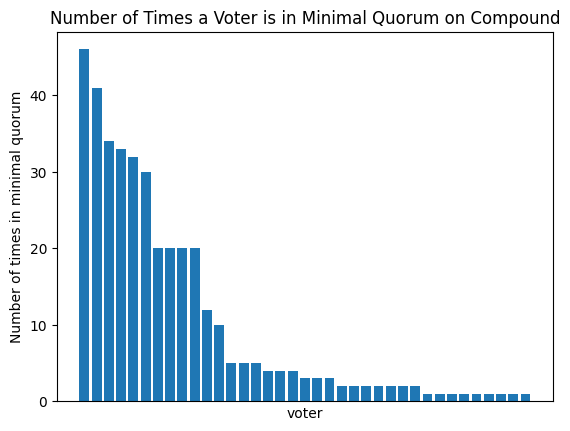

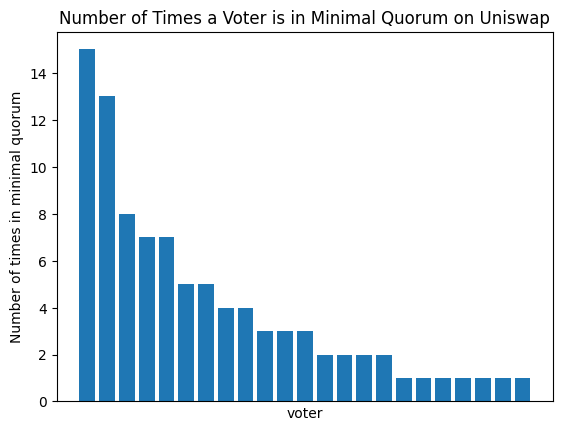

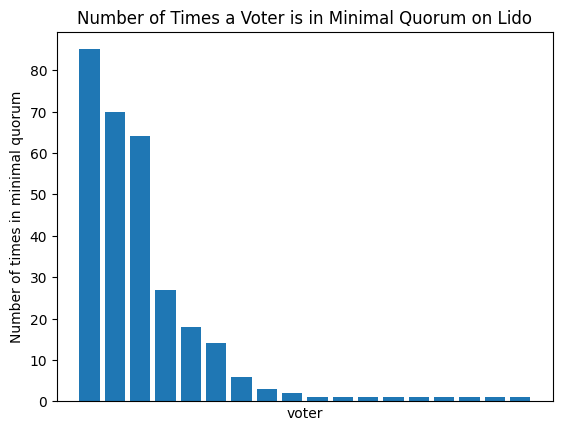

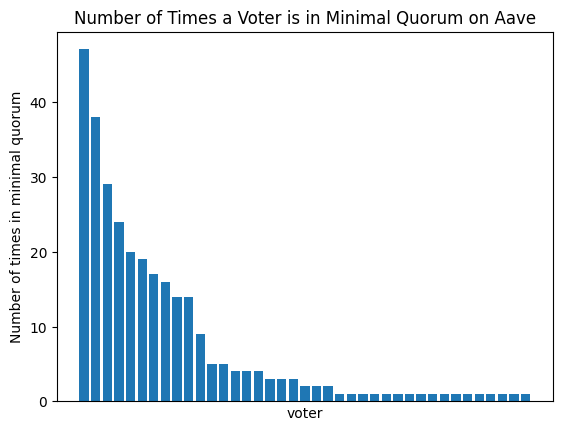

In [171]:
for x in platforms:
    mquorum_members_dfs[x] = mquorum_members_dfs[x].astype( {'voter': str, 'whale_count': int })
    plt.bar(mquorum_members_dfs[x]['voter'], mquorum_members_dfs[x]['whale_count'])
    plt.xticks(ticks=[])
    plt.xlabel("voter")
    plt.ylabel("Number of times in minimal quorum")
    plt.title(f"Number of Times a Voter is in Minimal Quorum on {x}")
    plt.savefig(f"{image_path}/{x}_count_minimal_quorum.pdf")
    plt.show()


In [172]:
aquorum_members_dfs = {}

for x in platforms:
    aquorum_members_dfs[x] = fsv.make_aquorum_members_dfs(csvs_dict[x]).sort_values(by='whale_count', ascending=False)
    print(f"Total number of voters in all {x} minimal quorums: {aquorum_members_dfs[x]['whale_count'].sum()}")
    print(f"Unique number of voters in all {x} minimal quorums: {len(aquorum_members_dfs[x].index)}")
    print(aquorum_members_dfs[x])
    print()

Total number of voters in all Compound minimal quorums: 395
Unique number of voters in all Compound minimal quorums: 51
                                         voter whale_count
6   0x54A37d93E57c5DA659F508069Cf65A381b61E189          47
23  0x9AA835Bc7b8cE13B9B0C9764A52FbF71AC62cCF1          39
13  0x6626593C237f530D15aE9980A95ef938Ac15c35c          34
34  0x683a4F9915D6216f73d6Df50151725036bD26C02          32
35  0xea6C3Db2e7FCA00Ea9d7211a03e83f568Fc13BF7          30
32  0x88FB3D509fC49B515BFEb04e23f53ba339563981          27
37  0x8d07D225a769b7Af3A923481E1FdF49180e6A265          23
9   0xAC5720d6EE2d7872b88914C9c5Fa9BF38e72FaF6          21
0   0xeD409c9fF60f3020abF9012bcd45Fc294f5608fF          19
1   0x8169522c2C57883E8EF80C498aAB7820dA539806          17
3   0x7e4A8391C728fEd9069B2962699AB416628B19Fa          14
33  0xd5447A7aa223268398CF7c38c2c580622CC98772          10
41  0x7AE109A63ff4DC852e063a673b40BED85D22E585           5
28  0x61258f12C459984F32b83C86A6Cc10aa339396dE        

In [173]:
uni_usd = pd.read_csv('../data/uniswap_usd.csv', header=None)
uni_usd.columns = ['timestamp', 'usd_price']
comp_usd = pd.read_csv('../data/compound_governance_token_usd.csv', header=None)
comp_usd.columns = ['timestamp', 'usd_price']
lido_usd = pd.read_csv('../data/lido_dao_usd.csv', header=None)
lido_usd.columns = ['timestamp', 'usd_price']
aave_usd = pd.read_csv('../data/aave_usd.csv', header=None)
aave_usd.columns = ['timestamp', 'usd_price']


uni_usd_2 = pd.read_csv('../data/regrabbed_uniswap_usd.csv', header=None)
uni_usd_2.columns = ['timestamp', 'usd_price']
comp_usd_2 = pd.read_csv('../data/regrabbed_compound_governance_token_usd.csv', header=None)
comp_usd_2.columns = ['timestamp', 'usd_price']
lido_usd_2 = pd.read_csv('../data/regrabbed_lido_dao_usd.csv', header=None)
lido_usd_2.columns = ['timestamp', 'usd_price']
aave_usd_2 = pd.read_csv('../data/regrabbed_aave_usd.csv', header=None)
aave_usd_2.columns = ['timestamp', 'usd_price']

uni_usd = pd.concat([uni_usd, uni_usd_2], ignore_index=True)
comp_usd = pd.concat([comp_usd, comp_usd_2], ignore_index=True)
lido_usd = pd.concat([lido_usd, lido_usd_2], ignore_index=True)
aave_usd = pd.concat([aave_usd, aave_usd_2], ignore_index=True)

compound_events_usd = [compound_csvs, comp_usd]
uniswap_events_usd = [uniswap_csvs, uni_usd]
lido_events_usd = [lido_csvs, lido_usd]
aave_events_usd = [aave_csvs, aave_usd]
combined_events_usd = [compound_events_usd, uniswap_events_usd, lido_events_usd, aave_events_usd]
platforms_events_usd = dict(zip(platforms, combined_events_usd))


In [174]:
sway_usd_dfs = {}

for x in platforms:
    proposals_usd = pd.DataFrame(
        columns=['proposalId', 'latest_event_name',
                 'timestamp', 'usd_amount_to_sway',
                 'min_voters','min_voters_voting_weight',
                 'avg_usd_of_swayers'])

    for event_csv in platforms_events_usd[x][0]:
        events_df = parse_event_csv(event_csv)

        if 'timestamp' in events_df.columns:
            events_df['timestamp'] = (events_df['timestamp'] - pd.Timestamp(
                    "1970-01-01")) // pd.Timedelta('1s')
           
            events_df['timestamp'] = events_df['timestamp'] * 1000

            events_df = events_df.sort_values(by='timestamp')


        if 'compound' in event_csv:
            events_df = events_df[events_df['timestamp'] >= 1592280000000]

        events_df = pd.merge_asof(events_df,
                                  platforms_events_usd[x][1].sort_values(by='timestamp'), on="timestamp", direction="nearest")

        for proposalId in events_df['proposalId'].dropna().unique():
            
            
            if 'timestamp' in events_df.columns:
                sorted_by_votes = events_df.loc[events_df['proposalId'] == proposalId,
                                                ['votes', 'voter', 'usd_price', 'timestamp']].sort_values(by='votes', ascending=False)
            else:
                sorted_by_votes = events_df.loc[events_df['proposalId'] == proposalId,
                                                ['votes', 'voter', 'usd_price']].sort_values(by='votes', ascending=False)


            majority = sorted_by_votes['votes'].sum() * 0.5
            cum_votes = cum_usd_price = 0
            min_voters = 0

            for ind in sorted_by_votes.index:

                if cum_votes > majority:
                    break
                cum_votes += sorted_by_votes['votes'][ind]
                # calculate USD price of votes at the time of the vote
                cum_usd_price += sorted_by_votes['votes'][ind] * sorted_by_votes['usd_price'][ind]
                min_voters += 1

            proposal_events = events_df.loc[events_df['id'] == proposalId, 'event_name']
            if not proposal_events.empty:
                latest_event_name = proposal_events.iloc[-1]
            else:
                latest_event_name = np.nan

            new_proposal = pd.DataFrame(
                    {'proposalId': proposalId, 'latest_event_name': latest_event_name,
                     'usd_amount_to_sway': [cum_usd_price], 'min_voters': min_voters,
                     'min_voters_voting_weight': cum_votes, 'avg_usd_of_swayers': (cum_usd_price / min_voters)})

            if 'timestamp' in events_df:
                new_proposal['timestamp'] = sorted_by_votes['timestamp'][ind]

            proposals_usd = pd.concat([proposals_usd, new_proposal], ignore_index=True)
            
    sway_usd_dfs[x] = proposals_usd

/var/folders/7j/n25596nn77l72d_967r5ds0w0000gn/T/ipykernel_19369/513837863.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  proposals_usd = pd.concat([proposals_usd, new_proposal], ignore_index=True)
/var/folders/7j/n25596nn77l72d_967r5ds0w0000gn/T/ipykernel_19369/513837863.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  proposals_usd = pd.concat([proposals_usd, new_proposal], ignore_index=True)
/var/folders/7j/n25596nn77l72d_967r5ds0w0000gn/T/ipykernel_19369/513837863.py:66: FutureWarn

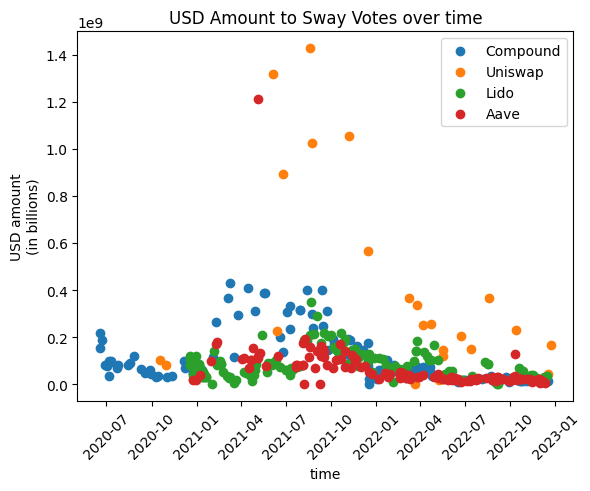

In [175]:
for x in platforms:
    # check that each dataframe has timestamps
    if not sway_usd_dfs[x]['timestamp'].isnull().all():
        timestamps = sway_usd_dfs[x]['timestamp']
        timestamps = pd.to_datetime(timestamps, unit='ms')
        plt.scatter(timestamps, sway_usd_dfs[x]['usd_amount_to_sway'], label=x)
plt.xticks(rotation=45)
plt.xlabel("time")
plt.ylabel("USD amount\n(in billions)")
plt.legend(loc="upper right")
plt.title("USD Amount to Sway Votes over time")

plt.savefig(f"{image_path}/usd_sway.pdf", bbox_inches = "tight")
plt.show()

In [176]:
min_quorum_voters_dict = {}
categorized_addresses = pd.read_csv('../data/categorized_addresses.csv')
print( categorized_addresses.columns )
for x in mquorum_members_dfs.keys():
    min_quorum_voters_dict[x] = mquorum_members_dfs[x].merge( categorized_addresses , on='voter', how='left') 

Index(['voter', 'compound_name', 'ens_name', 'sybil_name', 'category'], dtype='object')


In [177]:
addresses_to_tag = pd.DataFrame( columns = ['platform','voter'] )
for x in min_quorum_voters_dict.keys():

    mq_voters = min_quorum_voters_dict[x]
   
    no_names = mq_voters[ mq_voters.compound_name.isnull() & mq_voters.ens_name.isnull() & mq_voters.sybil_name.isnull() ]
    
    if no_names.shape[0] > 0:
        print( "==========" )
        print( x )
        print( no_names.voter )
        print( "==========" )
        addresses_to_tag = pd.concat( [addresses_to_tag, pd.DataFrame( {'voter': no_names.voter, 'platform': [x]*no_names.shape[0] } ) ] )
    
    print(f'{x} sum of minimal quorum voters across all proposals with no name {no_names.shape[0]}')
    print(f'{x} sum of minimal quorum voters across all proposals: {mq_voters.shape[0]}')
    print()

if addresses_to_tag.shape[0] > 0:
    addresses_to_tag.to_csv( "../data/untagged_addresses.csv", index=False )


Compound
23    0xB49f8b8613bE240213C1827e2E576044fFEC7948
26    0xC66e426404C742D81655A9D80Ce58fdbcEE468A9
28                                           nan
29    0xDB9F80F513A3bd5Ae7408484E679A1d86Eee1580
30    0x14Ee59975F7EE3A6aB8e9Bc81a7E634fa66285B4
31    0x2f04664B18FB9b6D49124FcC876B52A4ba797718
32    0x05C55b58B044342e89C343D2d6D53C08d26500Bb
34    0x4ca7B33AED8B13faAbB97724DdB3108500a3801e
35                                           nan
36                                           nan
38                                           nan
39                                           nan
40                                           nan
41                                           nan
42    0xA5dcEc366b04a127d0F4eFeE183346F25434d648
43                                           nan
44                                           nan
45                                           nan
46                                           nan
47                                           nan
48         

In [178]:
#Create dataframes
# 1 Dataframe for each platform
# 1 row for each ProposalId and member of the min quorum
mquorum_dict = {}
categorized_addresses = pd.read_csv('../data/categorized_addresses.csv')
uncategorized_addresses = pd.DataFrame( columns = ['voter','platform'] )
for x in platforms:
    df = fsv.make_mquorum_members_dfs_by_proposal(csvs_dict[x])
    df = df.merge( categorized_addresses, on='voter', how='left' )
    udf = df[df.category.isnull()].copy()
    udf['platform'] = [x]*udf.shape[0]
    udf.drop(columns=['proposalId','category'],inplace=True)
    uncategorized_addresses = pd.concat( [uncategorized_addresses,udf] )
    df.fillna({'category':'completely anonymous'},inplace=True)
    mquorum_dict[x] = df

uncategorized_addresses.drop_duplicates( subset=['voter'], inplace=True )
uncategorized_addresses.to_csv('../data/uncategorized_min_quorum_members.csv',index=False )

/Users/brett/sandbox/dao-governance/analysis/find_swaying_voters.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  swayers = pd.concat( [swayers,new_swayers] )
/Users/brett/sandbox/dao-governance/analysis/find_swaying_voters.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  swayers = pd.concat( [swayers,new_swayers] )
/Users/brett/sandbox/dao-governance/analysis/find_swaying_voters.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In 

In [179]:
print( mquorum_dict['Compound'].head() )
tdf = mquorum_dict['Compound'].groupby(['category'],as_index=False).size()
print( tdf.columns )

                                        voter  proposalId      compound_name  \
0  0xeD409c9fF60f3020abF9012bcd45Fc294f5608fF         1.0  Polychain Capital   
1  0x8169522c2C57883E8EF80C498aAB7820dA539806         1.0     Geoffrey Hayes   
2  0xE5A52921901C58971ba60725651Dc28bdE98BEB9         1.0     ParaFi Capital   
3  0xeD409c9fF60f3020abF9012bcd45Fc294f5608fF         2.0  Polychain Capital   
4  0x8169522c2C57883E8EF80C498aAB7820dA539806         2.0     Geoffrey Hayes   

  ens_name sybil_name          category  
0      NaN        NaN        investment  
1      NaN        NaN  Compound founder  
2      NaN        NaN        investment  
3      NaN        NaN        investment  
4      NaN        NaN  Compound founder  
Index(['category', 'size'], dtype='object')


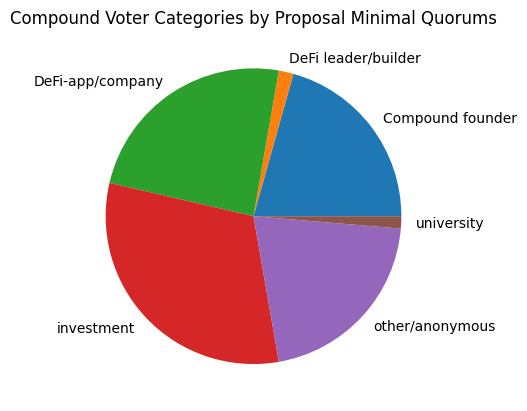

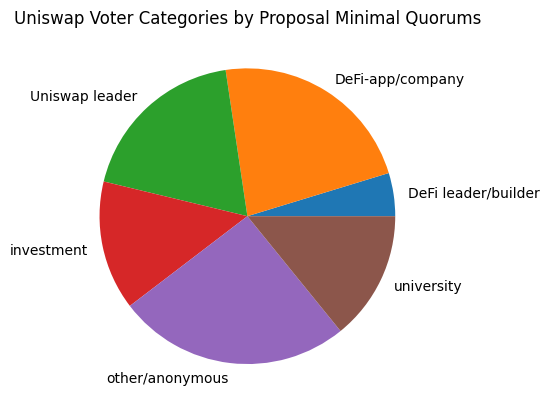

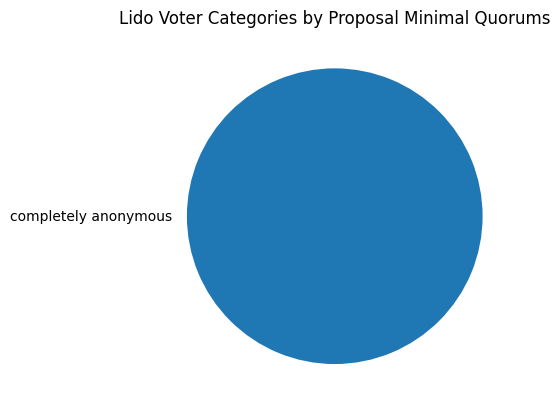

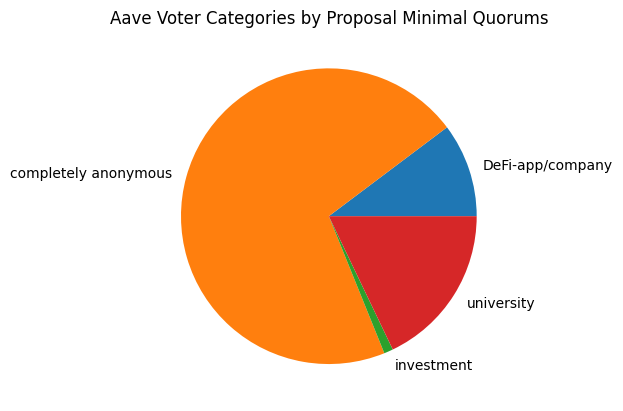

In [180]:
for x in platforms:

    x_mquorum_voters = mquorum_dict[x].copy() #Don't want to change categories multiple times if we re-run this cell
    
    if x == 'Uniswap':
        new_categories = {'completely anonymous':'other/anonymous', 'nonprofit':'other/anonymous',
                          'research-org':'other/anonymous','UGP':'Uniswap leader',
                          'investment':'investment', 'DeFi-app/company':'DeFi-app/company',
                         'founder':'DeFi leader/builder', 'university':'university'}
        x_mquorum_voters['category'] = x_mquorum_voters['category'].map(new_categories)
        
    if x == 'Compound':
        new_categories = {'Compound founder':'Compound founder', 'DeFi-app/company':'DeFi-app/company',
                         'completely anonymous':'other/anonymous', 'identified but anonymous':'other/anonymous',
                         'failed autonomous proposal': 'other/anonymous', 'founder':'DeFi leader/builder',
                         'investment':'investment', 'successful autonomous proposal':'other/anonymous',
                         'multiple governance contributor':'DeFi leader/builder', 'university':'university'}
        x_mquorum_voters['category'] = x_mquorum_voters['category'].map(new_categories)
    
    category_counts = x_mquorum_voters.groupby(['category'],as_index=False).size()
    
    plt.pie( category_counts['size'], labels=category_counts['category'] )
    
    plt.title(f"{x} Voter Categories by Proposal Minimal Quorums")
    
    plt.savefig(f"{image_path}/{x}_categories_pie.pdf", bbox_inches='tight')
    plt.show()

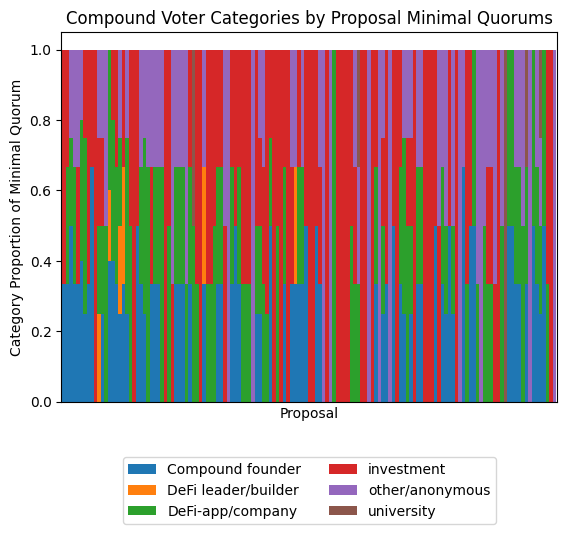

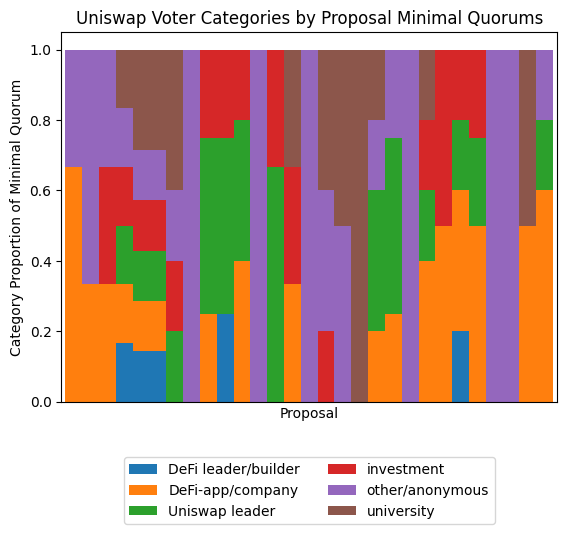

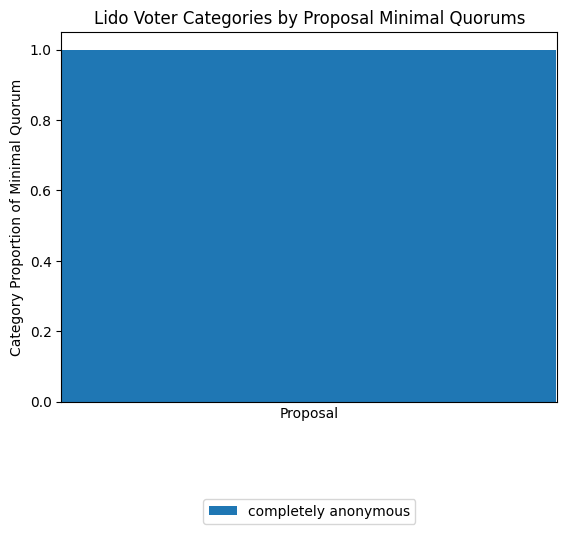

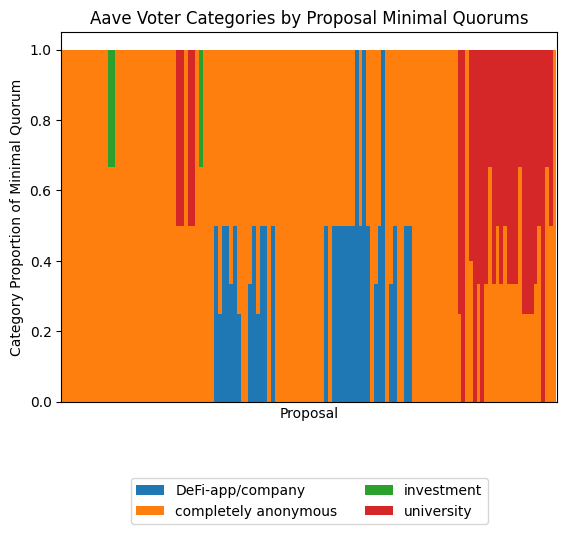

In [181]:
for x in platforms:

    x_mquorum_voters = mquorum_dict[x].copy() #Don't want to change categories multiple times if we re-run this cell
    
    if x == 'Uniswap':
        new_categories = {'completely anonymous':'other/anonymous', 'nonprofit':'other/anonymous',
                          'research-org':'other/anonymous','UGP':'Uniswap leader',
                          'investment':'investment', 'DeFi-app/company':'DeFi-app/company',
                         'founder':'DeFi leader/builder', 'university':'university'}
        x_mquorum_voters['category'] = x_mquorum_voters['category'].map(new_categories)
        
    if x == 'Compound':
        new_categories = {'Compound founder':'Compound founder', 'DeFi-app/company':'DeFi-app/company',
                         'completely anonymous':'other/anonymous', 'identified but anonymous':'other/anonymous',
                         'failed autonomous proposal': 'other/anonymous', 'founder':'DeFi leader/builder',
                         'investment':'investment', 'successful autonomous proposal':'other/anonymous',
                         'multiple governance contributor':'DeFi leader/builder', 'university':'university'}
        x_mquorum_voters['category'] = x_mquorum_voters['category'].map(new_categories)
        
    category_by_proposal = pd.crosstab(index=x_mquorum_voters['proposalId'],
                             columns=x_mquorum_voters['category'],
                             normalize="index")
    
    category_by_proposal.plot(kind='bar', 
                    stacked=True, width=1.0)
    
    plt.legend(ncol=2, loc='lower center', bbox_to_anchor = (0.5, -0.35))
    
    
    if x == 'Compound' or x == 'Aave' or 'Lido':
        # too many proposals for x-axis ticks
        plt.xticks([])
        
    plt.xlabel("Proposal")
    plt.ylabel("Category Proportion of Minimal Quorum")
    plt.title(f"{x} Voter Categories by Proposal Minimal Quorums")
    
    plt.savefig(f"{image_path}/{x}_categories.pdf", bbox_inches='tight')
    plt.show()

**Contentiousness**

In [182]:
# look at percentage of votes cast for winning side

contentiousness_dfs = {}

for x in platforms:
    
    contentiousness = pd.DataFrame(columns=['proposalId', 'support_votes', 'oppose_votes', 'total_votes',
                                            'support_voters', 'oppose_voters',
                                        'result'])
    
    for event_csv in csvs_dict[x]:
        events_df = parse_event_csv(event_csv)
        
        for proposalId in events_df['proposalId'].dropna().unique():
            
            if 'uniswap_governor_alphav2' in event_csv and proposalId == 5:
                continue
            
            support = events_df.loc[(events_df['proposalId'] == proposalId) & (events_df['support'] == True), 'votes']
            oppose = events_df.loc[(events_df['proposalId'] == proposalId) &  (events_df['support'] == False), 'votes']
            
            event_names = events_df.loc[events_df['id'] == proposalId, 'event_name']
            if not event_names.empty:
                latest_event_name = event_names.iloc[-1]
            else:
                latest_event_name = np.nan
            
#             if 'timestamp' in proposal_events.columns:
#                 proposal_events.loc[:, 'timestamp'] = pd.to_datetime(proposal_events.loc[:, 'timestamp'],
#                                                                      format='%Y-%m-%dT%H:%M:%S')
#                 timestamp = proposal_events['timestamp'].iloc[-1]
#             else:
#                 timestamp = np.nan
            
            new_proposal = pd.DataFrame({'proposalId':[proposalId],
                                         'support_votes':support.sum(),'oppose_votes':oppose.sum(),
                                         'total_votes':support.sum() + oppose.sum(),
                                         'support_voters':len(support), 'oppose_voters':len(oppose),
                                         'result': latest_event_name})
            
            contentiousness = pd.concat([contentiousness, new_proposal], ignore_index=True)
    
    contentiousness_dfs[x] = contentiousness


/var/folders/7j/n25596nn77l72d_967r5ds0w0000gn/T/ipykernel_19369/2659261339.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  contentiousness = pd.concat([contentiousness, new_proposal], ignore_index=True)
/var/folders/7j/n25596nn77l72d_967r5ds0w0000gn/T/ipykernel_19369/2659261339.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  contentiousness = pd.concat([contentiousness, new_proposal], ignore_index=True)
/var/folders/7j/n25596nn77l72d_967r5ds0w0000gn/T/ipykernel_19369/2659261339.py:41:

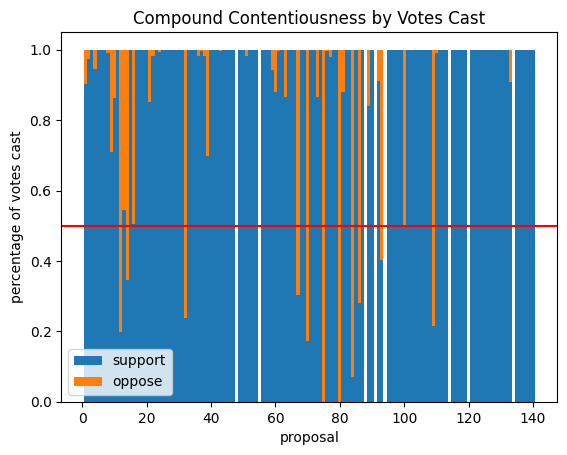

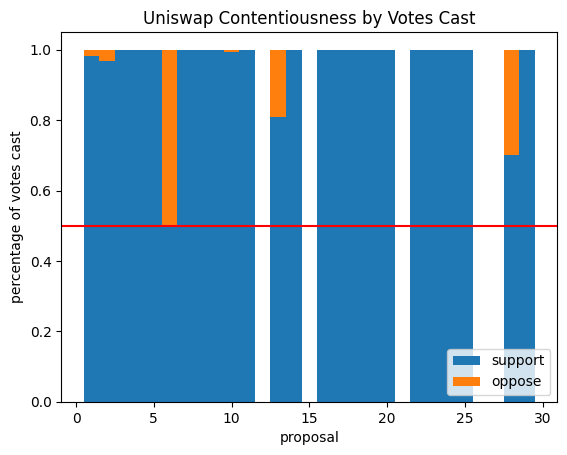

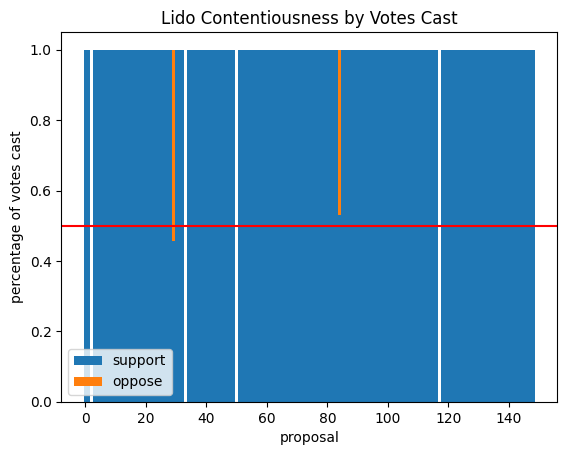

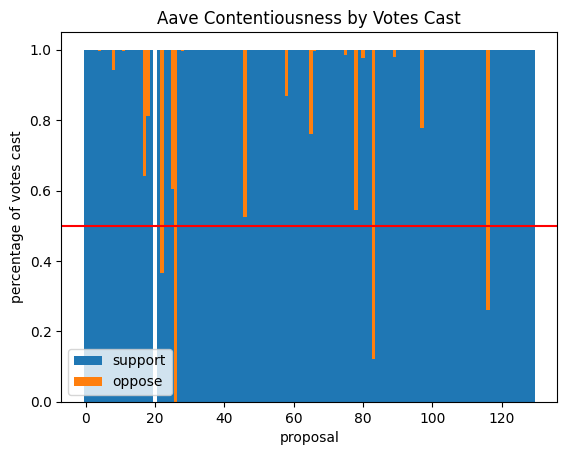

In [183]:
for x in platforms:
    votes_normalized = contentiousness_dfs[x].loc[:, ['proposalId', 'support_votes', 'oppose_votes']]
    votes_normalized.loc[:, 'support_votes_normalized'] = votes_normalized.loc[:, 'support_votes'] / (
        votes_normalized.loc[:, 'support_votes'] + votes_normalized.loc[:, 'oppose_votes'])
    votes_normalized.loc[:, 'oppose_votes_normalized'] = votes_normalized.loc[:, 'oppose_votes'] / (
        votes_normalized.loc[:, 'support_votes'] + votes_normalized.loc[:, 'oppose_votes'])
    votes_normalized.drop(columns=['support_votes', 'oppose_votes'], inplace=True)
    
    fig, ax = plt.subplots()

    ax.bar(votes_normalized['proposalId'], votes_normalized['support_votes_normalized'], label='support', width=1.0)
    ax.bar(votes_normalized['proposalId'], votes_normalized['oppose_votes_normalized'],
           bottom=votes_normalized['support_votes_normalized'], label='oppose', width=1.0)

    ax.set_ylabel('percentage of votes cast')
    ax.set_xlabel('proposal')
    ax.set_title(f'{x} Contentiousness by Votes Cast')
    ax.legend()
    
    plt.axhline(y=0.5, color='r', linestyle='-')
    
    plt.savefig(f"{image_path}/{x}_contentiousness_byvotes.pdf")
    plt.show()

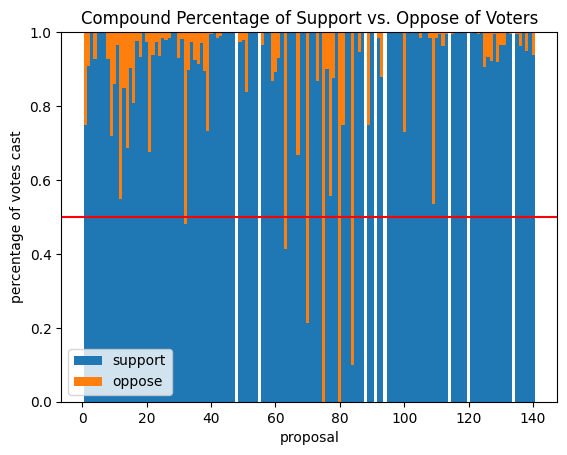

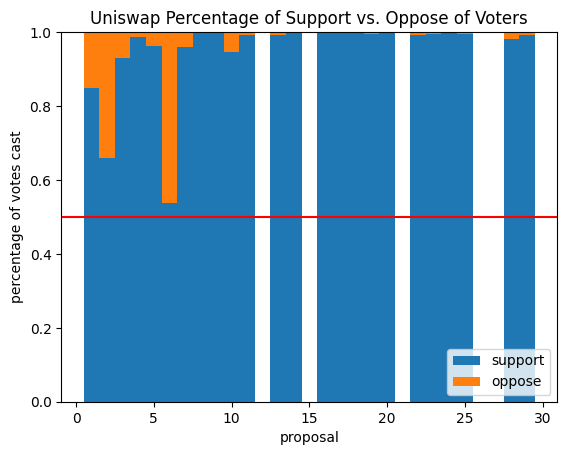

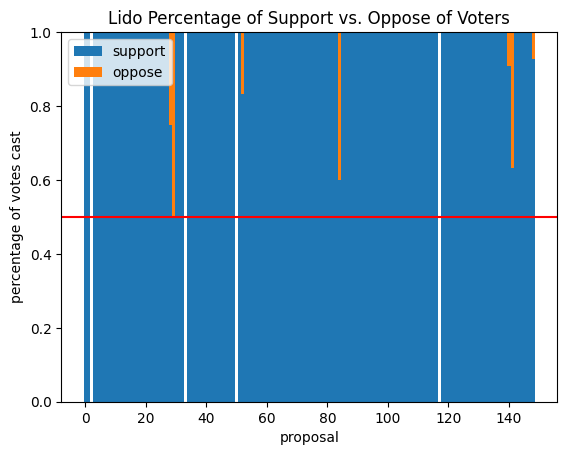

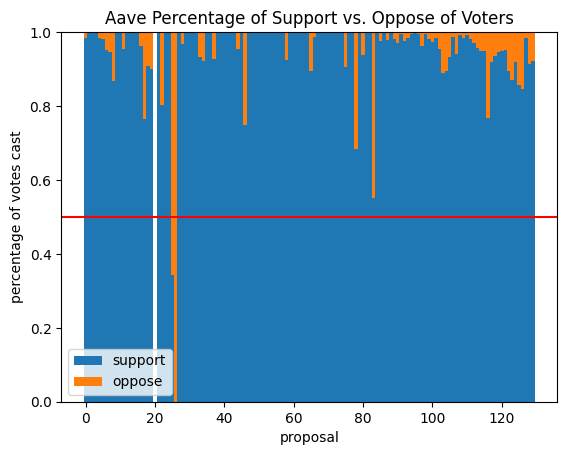

In [184]:
for x in platforms:
    voters_normalized = contentiousness_dfs[x][['proposalId', 'support_voters', 'oppose_voters']]
    voters_normalized = voters_normalized.astype( {'support_voters':float,'oppose_voters':float }) #Only floats support zero division
    voters_normalized['support_voters_normalized'] = voters_normalized['support_voters'].divide(
        voters_normalized['support_voters'] + voters_normalized['oppose_voters'])
    voters_normalized['oppose_voters_normalized'] = voters_normalized['oppose_voters'].div(
        voters_normalized['support_voters'] + voters_normalized['oppose_voters'])
    voters_normalized.drop(columns=['support_voters', 'oppose_voters'], inplace=True)
    
    fig, ax = plt.subplots()

    ax.bar(voters_normalized['proposalId'], voters_normalized['support_voters_normalized'], label='support', width=1.0)
    ax.bar(voters_normalized['proposalId'], voters_normalized['oppose_voters_normalized'],
           bottom=voters_normalized['support_voters_normalized'], label='oppose', width=1.0)

    ax.set_ylabel('percentage of votes cast')
    ax.set_xlabel('proposal')
    ax.set_title(f'{x} Percentage of Support vs. Oppose of Voters')
    ax.legend()
    
    plt.axhline(y=0.5, color='r', linestyle='-')

    plt.show()

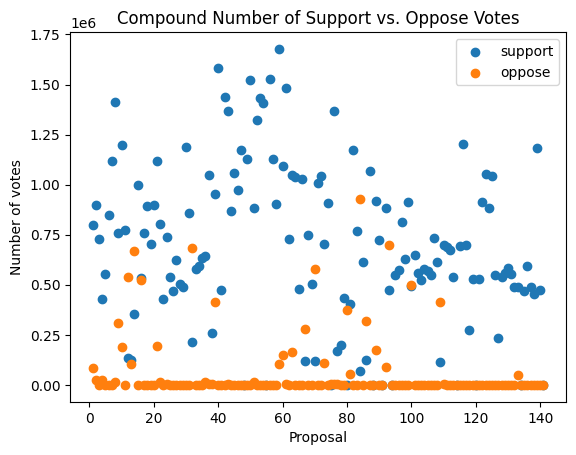

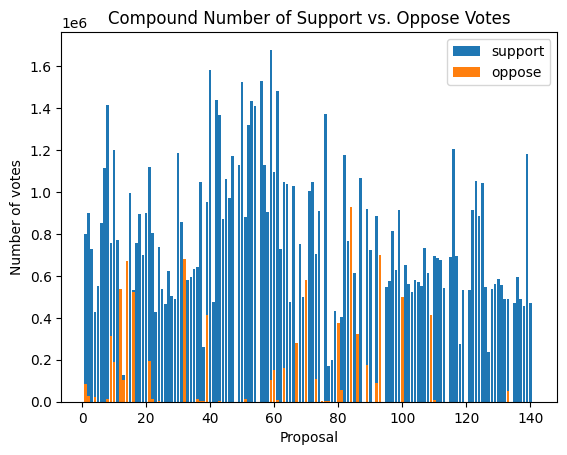

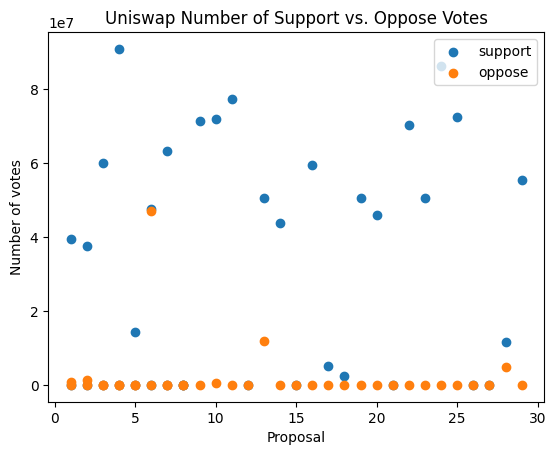

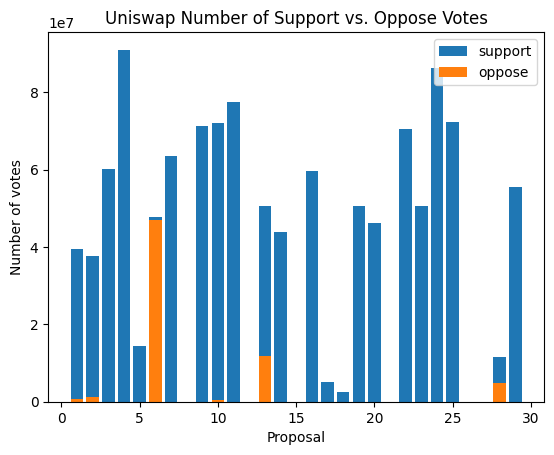

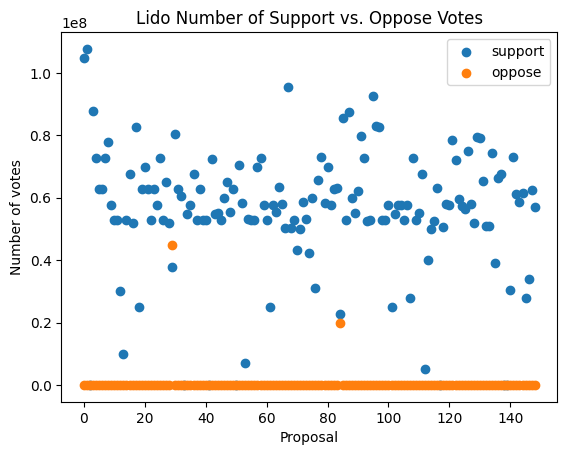

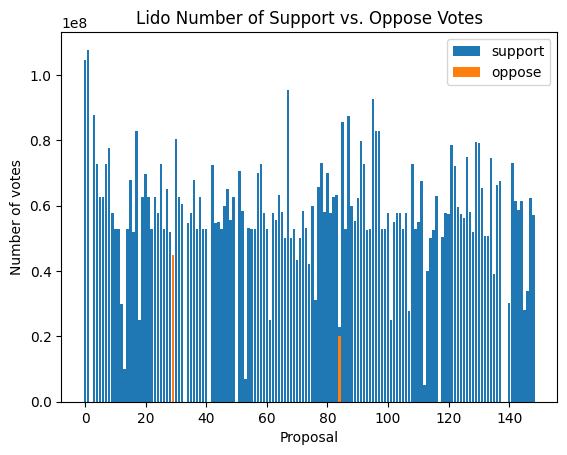

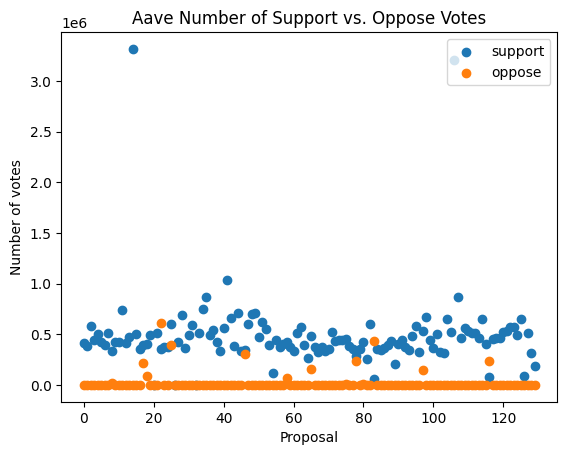

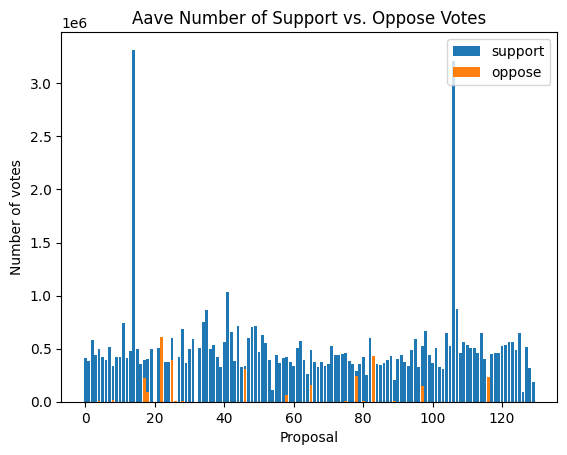

In [185]:

for x in platforms:
    plt.scatter(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['support_votes'], label='support')
    plt.scatter(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['oppose_votes'], label='oppose')
    plt.xlabel("Proposal")
    plt.ylabel("Number of votes")
    plt.title(f'{x} Number of Support vs. Oppose Votes')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.bar(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['support_votes'], label='support')
    plt.bar(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['oppose_votes'], label='oppose')
    plt.xlabel("Proposal")
    plt.ylabel("Number of votes")
    plt.title(f'{x} Number of Support vs. Oppose Votes')
    plt.legend(loc="upper right")
    plt.show()
    

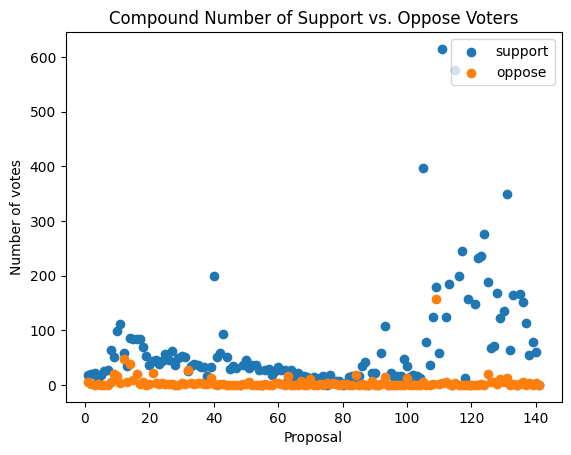

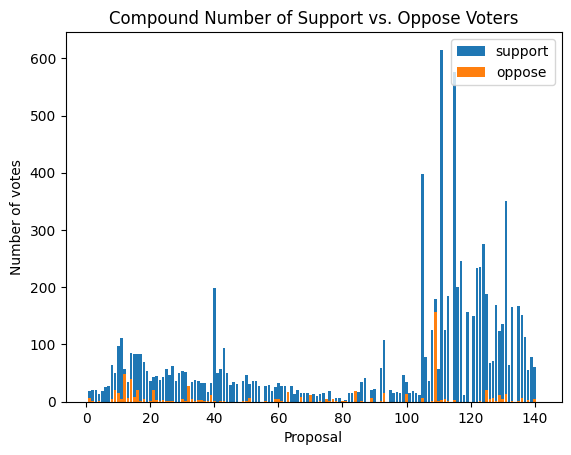

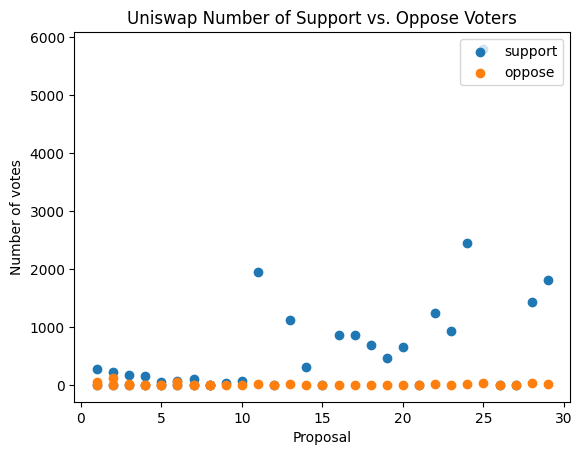

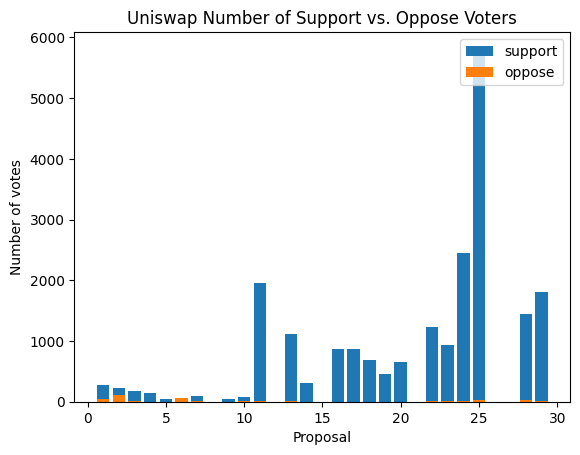

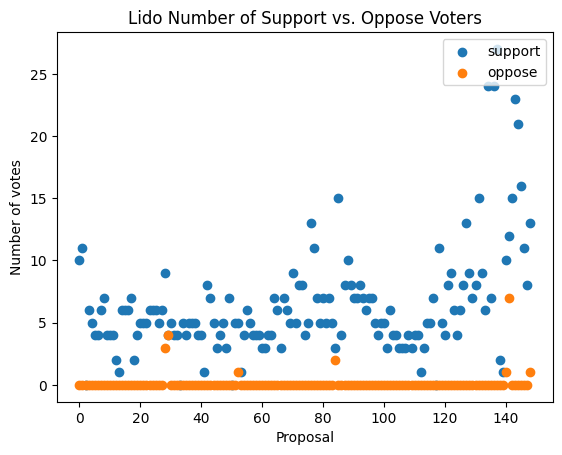

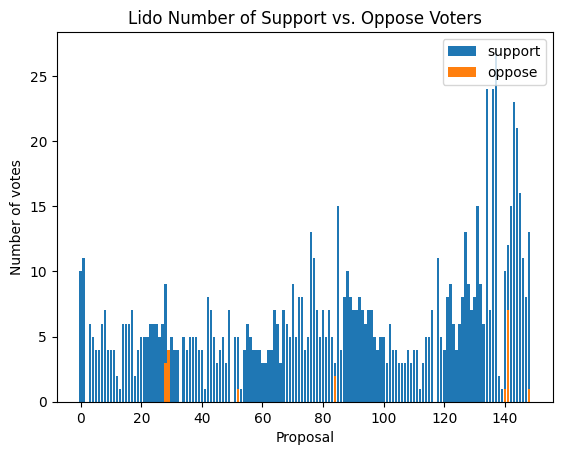

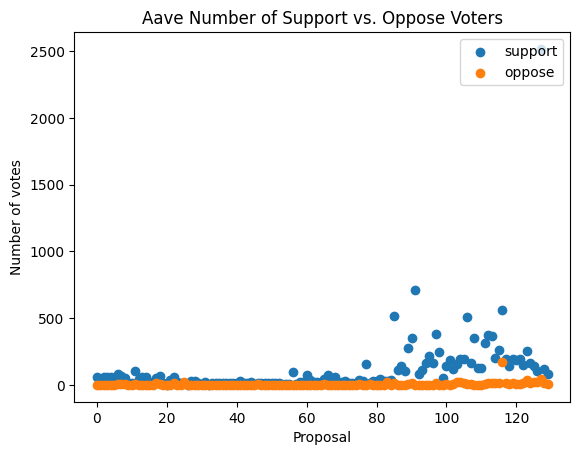

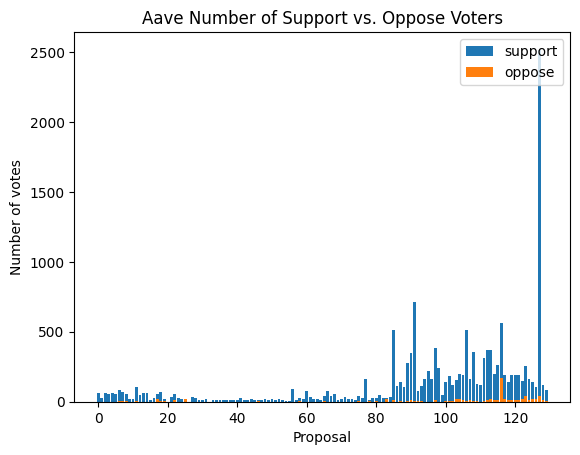

In [186]:
for x in platforms:
    plt.scatter(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['support_voters'], label='support')
    plt.scatter(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['oppose_voters'], label='oppose')
    plt.xlabel("Proposal")
    plt.ylabel("Number of votes")
    plt.title(f'{x} Number of Support vs. Oppose Voters')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.bar(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['support_voters'], label='support')
    plt.bar(contentiousness_dfs[x]['proposalId'], contentiousness_dfs[x]['oppose_voters'], label='oppose')
    plt.xlabel("Proposal")
    plt.ylabel("Number of votes")
    plt.title(f'{x} Number of Support vs. Oppose Voters')
    plt.legend(loc="upper right")
    plt.show()